### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2021-10-17 09:18:55--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.111.59
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.111.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  53.8MB/s    in 6m 6s   

2021-10-17 09:25:02 (50.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-10-17 09:25:02--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.114.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.114.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  65.4MB/s    in 11s     

2021-10-17 09:25:13 (69.3 MB/s) - ‘val

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img = imageio.imread('data/train2017/000000000025.jpg')

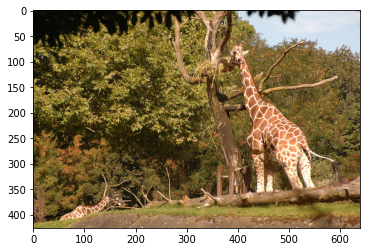

In [ ]:
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

In [ ]:
img

Array([[[0.03137255, 0.03529412, 0.01568628],
        [0.03137255, 0.03529412, 0.01568628],
        [0.02745098, 0.03137255, 0.01176471],
        ...,
        [0.23137255, 0.23529412, 0.2509804 ],
        [0.22745098, 0.22352941, 0.25490198],
        [0.2784314 , 0.27058825, 0.3137255 ]],

       [[0.03137255, 0.03529412, 0.01568628],
        [0.03137255, 0.03529412, 0.01568628],
        [0.02745098, 0.03137255, 0.01176471],
        ...,
        [0.5921569 , 0.5882353 , 0.60784316],
        [0.5803922 , 0.5764706 , 0.6       ],
        [0.5882353 , 0.58431375, 0.6156863 ]],

       [[0.03137255, 0.03529412, 0.01568628],
        [0.02745098, 0.03137255, 0.01176471],
        [0.02745098, 0.03137255, 0.01176471],
        ...,
        [0.73333335, 0.73333335, 0.7411765 ],
        [0.7058824 , 0.7019608 , 0.72156864],
        [0.6745098 , 0.67058825, 0.6901961 ]],

       ...,

       [[0.7490196 , 0.7411765 , 0.3372549 ],
        [0.68235296, 0.6509804 , 0.26666668],
        [0.5803922 , 0

### Импорт необходимых библиотек

In [ ]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [ ]:
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname)) # путь к картинкам
        
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

#train_ds = COCO_dataset_train.train_dataset(...)
#val_ds = COCO_dataset_val.val_dataset(...)

loading annotations into memory...
Done (t=20.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [ ]:
IMG_SHAPE = 256

In [ ]:
train_ds = COCO_dataset_train.train_dataset(batch_size=64, epochs=1, inp_size=IMG_SHAPE)
val_ds = COCO_dataset_val.val_dataset(batch_size=64, inp_size=IMG_SHAPE)

# FCN модель

In [ ]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)(out) #sigmoid

    #out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
    out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
    out = tf.nn.sigmoid(out)
    
    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [ ]:
# class Model(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
#                                             input_shape=(IMG_SHAPE, IMG_SHAPE, 3))
#         self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
#         self.pool = tf.keras.layers.MaxPool2D((2, 2))
        
#     def call(self, x):
#         x = tf.keras.layers.Input((256, 256, 3))
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.pool(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.pool(out)
#         out = self.conv5(out)
#         out = self.conv6(out)
#         out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
#         out = tf.nn.sigmoid(out)
#         return out
    
# model = Model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
NUM_EPOCHS = 2
BATCH_SIZE = 64
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [18]:
#history1 = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, steps_per_epoch=80)
history1 = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, steps_per_epoch=200)

Epoch 1/2
200/200 [==============================] - 11562s 58s/step - loss: 0.4602 - accuracy: 0.7828 - val_loss: 0.4980 - val_accuracy: 0.7671
Epoch 2/2
200/200 [==============================] - 11585s 58s/step - loss: 0.4415 - accuracy: 0.7905 - val_loss: 0.4529 - val_accuracy: 0.7807


In [19]:
import matplotlib.pyplot as plt

In [20]:
history1.history['loss']

[0.4602011442184448, 0.4415401220321655]

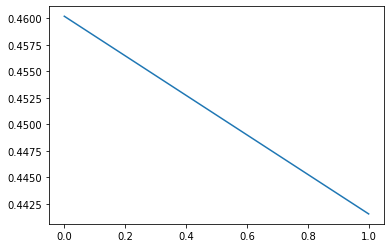

In [21]:
plt.plot(history1.history['loss'])

In [39]:
from skimage.transform import resize
names = ['000000000009.jpg', '000000000025.jpg', '000000000030.jpg']

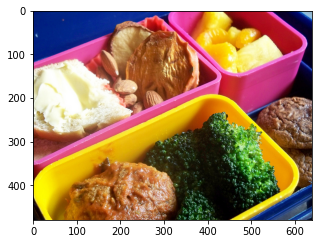

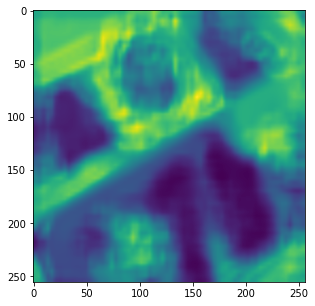

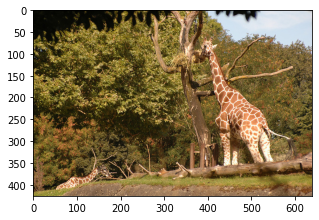

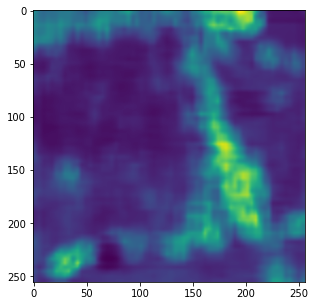

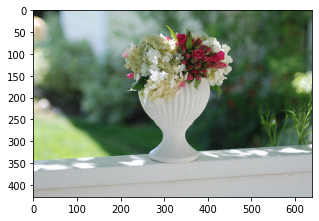

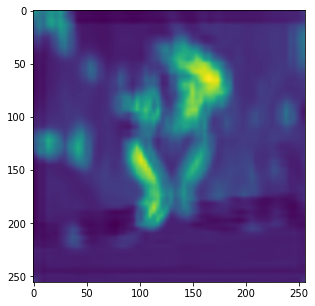

In [47]:
for name in names:
  img = imageio.imread('data/train2017/' + name)
  img = img.astype(np.float32) / 255.
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  img_inp = resize(img, (256, 256), 
                    order=3, mode='reflect', anti_aliasing=True)
  out = model.predict(img_inp[None, ...])
  plt.figure(figsize=(5, 5))
  plt.imshow(out[0, ..., 0])


In [51]:
img.shape, img_inp.shape, out[0, ..., 0].shape

((428, 640, 3), (256, 256, 3), (256, 256))

In [52]:
out

array([[[[0.29784498],
         [0.29784498],
         [0.2924794 ],
         ...,
         [0.10757077],
         [0.11224899],
         [0.11224899]],

        [[0.29784498],
         [0.29784498],
         [0.2924794 ],
         ...,
         [0.10757077],
         [0.11224899],
         [0.11224899]],

        [[0.29099554],
         [0.29099554],
         [0.2862873 ],
         ...,
         [0.10599104],
         [0.11032879],
         [0.11032879]],

        ...,

        [[0.10377106],
         [0.10377106],
         [0.10043243],
         ...,
         [0.09040251],
         [0.09410071],
         [0.09410071]],

        [[0.10855162],
         [0.10855162],
         [0.10454682],
         ...,
         [0.0917879 ],
         [0.09598786],
         [0.09598786]],

        [[0.10855162],
         [0.10855162],
         [0.10454682],
         ...,
         [0.0917879 ],
         [0.09598786],
         [0.09598786]]]], dtype=float32)

# FCN модель (stride + UpSampling2D)

In [ ]:
def build_model():
  # Encoder
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    #Decoder
    out = tf.keras.layers.UpSampling2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.UpSampling2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

NameError: ignored

In [ ]:
# class Model(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        
#         self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')
        
#         self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        
#         self.conv6 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')
        
#         self.conv7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        
#         self.conv9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        
#         self.conv11 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv12 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')
        
#         self.unpool = tf.keras.layers.UpSampling2D((2, 2))
                
#     def call(self, x):
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.conv3(out)
        
#         out = self.conv4(out)
#         out = self.conv5(out)
#         out = self.conv6(out)
        
#         out = self.conv7(out)
#         out = self.conv8(out)
#         out = self.unpool(out)
        
#         out = self.conv9(out)
#         out = self.conv10(out)
#         out = self.unpool(out)
        
#         out = self.conv11(out)
#         out = self.conv12(out)

#         return out
    
# model = Model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       1475

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
history2 = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, steps_per_epoch=80)

Epoch 1/2


In [ ]:
plt.plot(history2.history['loss'])

# FCN модель (U-net)

In [ ]:
def build_model():
  # Encoder
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)
    #out = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out1)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)
    #out = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out2)
    

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)
    #out = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)
    #out = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    #Decoder
    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [ ]:
model.summary()

In [ ]:
history3 = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, steps_per_epoch=80)

In [ ]:
plt.plot(history3.history['loss'])

# FCN модель (ASPP)

In [ ]:
def build_model():
    # Encoder
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)
    #out = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out1)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)
    #out = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out2)
    

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out_enc_mid = out
    out = tf.keras.layers.MaxPool2D((2, 2))(out)
    #out = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)
    #out = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    # ASPP
    out1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(out)
    out = tf.concat([out1, out2, out3, out4], axis=3)
    out = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out)

    # Decoder
    out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)
    out_enc_mid = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')(out_enc_mid)
    out = tf.concat([out, out_enc_mid], axis=3)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)(out)

    out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
    out = tf.nn.sigmoid(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [ ]:
# class ASPPBlock(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
#         self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
#         self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
#         self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
#         self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

#     def call(self, inp, is_training=False):
#         out1 = self.conv1(inp)
#         out2 = self.conv2(inp)
#         out3 = self.conv3(inp)
#         out4 = self.conv4(inp)
#         out = tf.concat([out1, out2, out3, out4], axis=3)
#         out = self.conv5(out)
#         return out
    
# class ASPPNet(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
#         self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
#         self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
#         self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
#         self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

#         self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
#         self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
#         self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

#         self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

#         self.aspp = ASPPBlock()

#     def call(self, x):

#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.maxpool(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.maxpool(out)
#         out = self.conv5(out)
#         out = self.conv6(out)
#         out_enc_mid = out
#         out = self.maxpool(out)
#         out = self.conv7(out)
#         out = self.conv8(out)
#         out = self.maxpool(out)
#         out = self.conv9(out)
#         out = self.conv10(out)

#         out = self.aspp(out)

#         out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

#         out_enc_mid = self.conv11(out_enc_mid)

#         out = tf.concat([out, out_enc_mid], axis=3)

#         out = self.conv12(out)
#         out = self.conv13(out)
#         out = self.conv14(out)

#         out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
#         out = tf.nn.sigmoid(out)
#         return out
    
# model = ASPPNet()

In [ ]:
model.summary()

In [ ]:
history4 = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, steps_per_epoch=80)

In [ ]:
plt.plot(history4.history['loss'])